In [31]:
import pandas as pd

In [32]:
df = pd.read_csv('country_data.csv')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [34]:
df.duplicated().sum()

np.int64(0)

In [35]:
unique_countries = df['country'].nunique()
unique_countries

167

In [36]:
country_names = df['country']
data = df.drop(columns=['country'])

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

### PCA

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

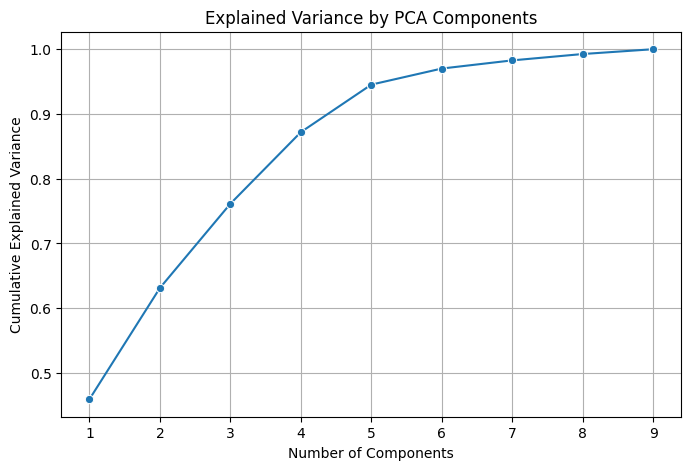

In [39]:
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Explained variance ratio
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1),
             y=pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [40]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(scaled_data)

In [41]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Variance:", pca.explained_variance_ratio_.cumsum())

Explained Variance Ratio: [0.4595174  0.17181626 0.13004259 0.11053162 0.07340211]
Cumulative Variance: [0.4595174  0.63133365 0.76137624 0.87190786 0.94530998]


In [42]:
pca_components = pd.DataFrame(
    pca.components_,
    columns=df.drop(columns=['country']).columns,
    index=[f'PC{i+1}' for i in range(5)]
)

pca_components


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
PC1,-0.419519,0.283897,0.150838,0.161482,0.398441,-0.193173,0.425839,-0.403729,0.392645
PC2,0.192884,0.613163,-0.243087,0.671821,0.022536,-0.008404,-0.222707,0.155233,-0.046022
PC3,-0.029544,0.144761,-0.596632,-0.299927,0.301548,0.642520,0.113919,0.019549,0.122977
PC4,0.370653,0.003091,0.461897,-0.071907,0.392159,0.150442,-0.203797,0.378304,0.531995
PC5,-0.168970,0.057616,0.518000,0.255376,-0.247150,0.714869,0.108220,-0.135262,-0.180167


### K-Means CLustering

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [44]:
inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)

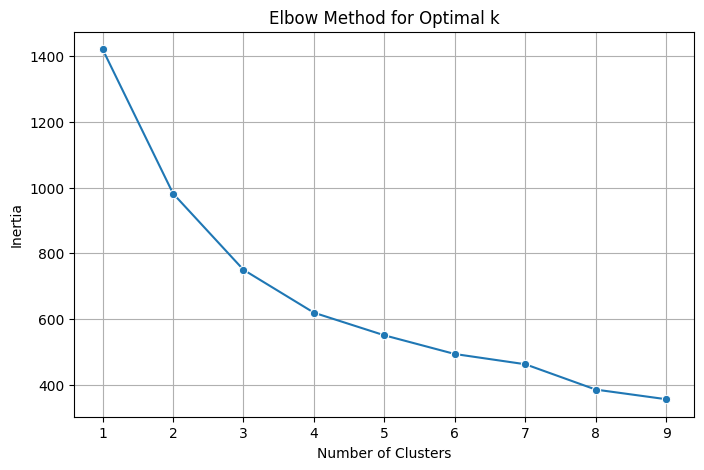

In [45]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 10), y=inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

Silhouette

In [46]:
range_n_clusters = range(2, 11)
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    score = silhouette_score(pca_data, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")

k = 2, Silhouette Score = 0.2849
k = 3, Silhouette Score = 0.3103
k = 4, Silhouette Score = 0.3287
k = 5, Silhouette Score = 0.2498
k = 6, Silhouette Score = 0.2558
k = 7, Silhouette Score = 0.2356
k = 8, Silhouette Score = 0.2582
k = 9, Silhouette Score = 0.2378
k = 10, Silhouette Score = 0.2427


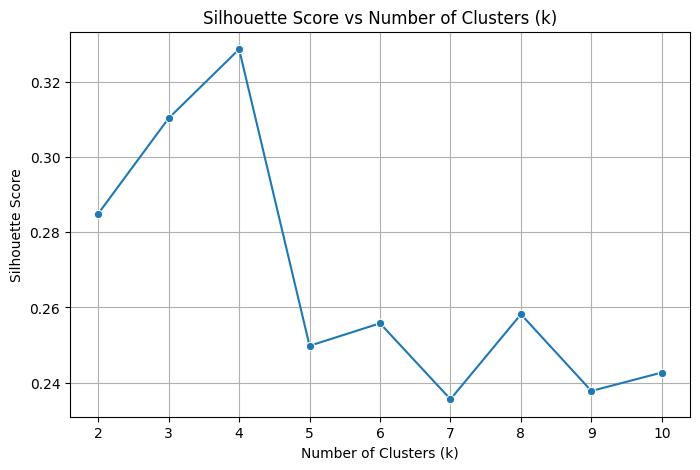

In [47]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range_n_clusters), y=silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

Final Model

In [48]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

In [49]:
final_kmeans_df = df.copy()
final_kmeans_df['KMeans_Cluster'] = kmeans_labels

In [54]:
import numpy as np

numeric_df = final_kmeans_df.select_dtypes(include=[np.number])

cluster_summary = numeric_df.groupby(final_kmeans_df['KMeans_Cluster']).mean()

cluster_summary


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,KMeans_Cluster
KMeans_Cluster,,,,,,,,,,
0,22.456977,40.273128,6.251047,47.362394,12321.744186,7.720884,72.566279,2.340349,6461.767442,0.0
1,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778,42494.444444,1.0
2,94.313636,28.677500,6.329091,42.872727,3503.250000,9.895568,59.022727,5.047727,1753.909091,2.0
3,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000,3.0


### Hierachical Clustering

In [57]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [58]:
linked = linkage(scaled_data, method='ward')

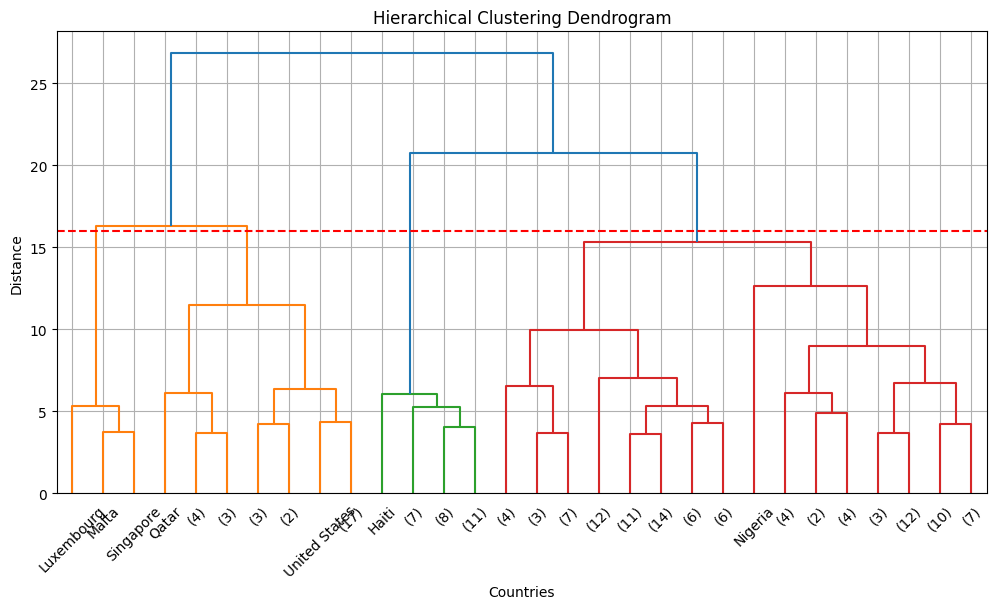

In [66]:
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=df['country'].values, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Countries")
plt.ylabel("Distance")
plt.grid(True)

plt.axhline(y=16, color='r', linestyle='--')
plt.show()

In [67]:
cluster_labels = fcluster(linked, 4, criterion='maxclust')

hierarchical_result = df.copy()
hierarchical_result['Hierarchical_Cluster'] = cluster_labels

numeric_df = hierarchical_result.select_dtypes(include=[np.number])
cluster_summary_hierarchical = numeric_df.groupby(hierarchical_result['Hierarchical_Cluster']).mean()

cluster_summary_hierarchical

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Hierarchical_Cluster
Hierarchical_Cluster,,,,,,,,,,
1,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,1.0
2,6.138710,47.138710,8.666452,38.474194,45996.774194,4.274935,79.841935,1.937742,41777.419355,2.0
3,105.070370,23.589630,6.507037,39.662963,1589.740741,7.142778,57.248148,5.433704,667.888889,3.0
4,31.617925,39.990368,6.353679,48.085527,11341.886792,9.120604,70.921698,2.654623,6407.367925,4.0
